In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [2]:
class LeastSquaresClassifier(object):
    """Linear least squares classifier with l2 regularization
    
    Parameters
    ----------
    X : {array-like, sparse matrix},
    shape = [n_samples, n_features]
        Training data
    
    y : array-like, shape = [n_samples]
        Training targets
        
    lambda_par : float
        Regularization strength
    
    """
    def __init__(self, X, y, lambda_par=0):
        self.U, self.S, self.V = np.linalg.svd(X, full_matrices = False)
        self.y = y
        self.lambda_par = lambda_par

    def train(self):
        """Train the Least Squares model
        
        Find the weights for each feature
        """
        s_inv = np.diag(list(map((lambda x: x / (self.lambda_par + x**2)), self.S)))
        self.w_params = np.dot(np.dot(np.dot(self.V.T, s_inv), self.U.T), self.y)
        
    def predict(self, x_test):
        """Predict the class for every point in the test set

        Parameters
        ----------
        x_test : array-like, shape = [n_samples, n_features]
            Test data
            
        Returns
        ----------
        pred : array-like, shape = [n_samples]
            Predictions made by the classifier   
        """
        pred = np.sign(np.dot(x_test, self.w_params))
        return pred
    
    def getParams(self):
        """Return the weights

        Returns
        ----------
        w_params : array-like, shape = [n_features]
            Weights for each feature   
        """
        return self.w_params
    
    def reverse_w(self):
        """Reverse the weights
        
        For boosting when the error term > 0.5
        """
        self.w_params *= -1   

In [3]:
class AdaBoost(object):
    """AdaBoost Ensemble Classifier
    
    Parameters
    ----------
    x_train : {array-like, sparse matrix},
    shape = [n_samples, n_features]
        Training data
    
    y_train : array-like, shape = [n_samples]
        Training targets
        
    classifier : callable
        Classifier to boost
    
    """
    def __init__(self, x_train, y_train, classifier):
        self.X = x_train
        self.y = y_train
        self.classifier = classifier
        self.probabilities = pd.DataFrame(np.ones(len(x_train))/len(x_train))
        
        self.errors = []
        self.alphas = []
        self.training_errors = []
        self.testing_errors = []
        self.classifiers = []
        self.upper_bounds = []
        
        self.all_samples = []
        
    def update_probabilities(self, alpha, predictions):
        """Update the probabilities given the new alpha and predictions

        Parameters
        ----------
        alpha : float
            alpha parameter
            
        predictions : array-like, shape = [n_samples]
            predicted classes

        """
        self.probabilities *= np.exp(-alpha*self.y*predictions)
        self.probabilities /= self.probabilities.sum()
            
    def compute_error(self, predictions):
        """Compute the error value

        Parameters
        ----------
        predictions : array-like, shape = [n_samples]
            predicted classes
            
        Returns
        ----------
        error : float
            adaboost error term  
        """
        misclassified = predictions != self.y
        error = float((misclassified * self.probabilities).sum())
        return error
    
    def compute_alpha(self, error):
        """Compute the alpha value given the error

        Parameters
        ----------
        error : float
            adaboost error term 
            
        Returns
        ----------
        alpha : float
            adaboost alpha term  
        """
        alpha = 0.5*np.log((1-error)/error)
        return alpha
    
    def append_error(self, error_type, sum_val, y_test = None):
        """Predict and store the errors for later analysis

        Parameters
        ----------
        error_type : string
            Specifiy whether training or testing error
            
        sum_val : float
            Accumulated sum over train or testing predictions scaled by alpha
            
        y_test : array-like, shape = [n_samples]
            Testing targets
        """
        boosted_prediction = np.sign(sum_val)
        if error_type == 'training':
            training_error = (boosted_prediction != self.y).sum()/len(self.y)
            self.training_errors.append(training_error)
        elif error_type == 'testing':
            testing_error = (boosted_prediction != y_test).sum()/len(y_test)
            self.testing_errors.append(testing_error)
        
    def ada_boost(self, x_test, y_test, iterations):
        """Perform all parts of the Ada Boost algorithm

        Parameters
        ----------
        x_test : array-like, shape = [n_samples, n_features]
            Test data
            
        y_test : array-like, shape = [n_samples]
            Testing targets
            
        iterations : integer
            Number of iterations to run the boosted classifier
            
        """
        
        training_sum = 0
        boosted_sum = 0
        bound_sum = 0

        for t in range(iterations):
            bootstrap_sample_x = self.X.sample(n = len(self.X), replace = True, weights = self.probabilities[0])
            bootstrap_sample_y = self.y.iloc[bootstrap_sample_x.index]
            self.all_samples.extend(bootstrap_sample_x.index)
            
            model = self.classifier(bootstrap_sample_x, bootstrap_sample_y)
            model.train()
            
            predictions = model.predict(self.X)
            error = self.compute_error(predictions)
            
            if error > 0.5:
                model.reverse_w()
                predictions = model.predict(self.X)
                error = self.compute_error(predictions)
            
            alpha = self.compute_alpha(error)
            
            bound_sum += ((0.5-error)**2)
            self.upper_bounds.append(np.exp(-2*bound_sum))
            
            weighted_prediction_train = pd.DataFrame(predictions) * alpha
            training_sum += weighted_prediction_train
            self.append_error('training', training_sum)
            
            weighted_prediction_test = pd.DataFrame(model.predict(x_test)) * alpha
            boosted_sum += weighted_prediction_test
            self.append_error('testing', boosted_sum, y_test)
            
            self.update_probabilities(alpha, predictions)
            
            self.alphas.append(alpha)
            self.errors.append(error)
            self.classifiers.append(model)

In [4]:
# Read in the data
x_train = pd.read_csv('data/X_train.csv', header = None)
y_train = pd.read_csv('data/y_train.csv', header = None)
x_test= pd.read_csv('data/X_test.csv', header = None)
y_test = pd.read_csv('data/y_test.csv', header = None)

# Add bias dimension
x_train[5] = 1
x_test[5] = 1

In [5]:
# Train and run the Ada Boost classifier
ada = AdaBoost(x_train, y_train, LeastSquaresClassifier)
ada.ada_boost(x_test, y_test, 1500)

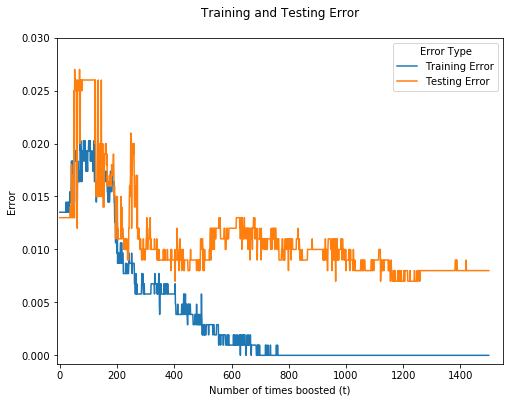

In [6]:
# Plot the Training and Testing Error
plt.figure(figsize = (8,6))
plt.plot(list(range(1500)), ada.training_errors, label = 'Training Error')
plt.plot(list(range(1500)), ada.testing_errors, label = 'Testing Error')
plt.title('Training and Testing Error\n')
plt.xlabel('Number of times boosted (t)')
plt.ylabel('Error')
plt.legend(title = 'Error Type')
plt.ylim([-0.0008,0.03])
plt.xlim([-10,1550]);

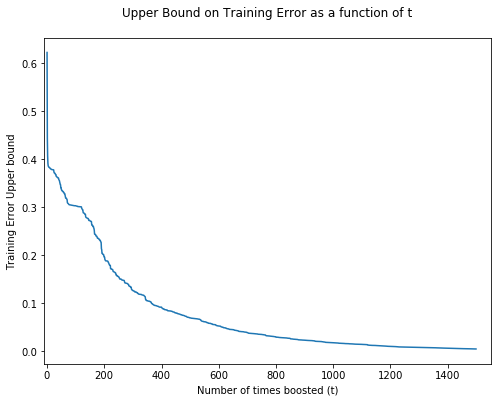

In [7]:
#Plot the upper bound on the training error
plt.figure(figsize = (8,6))
plt.plot(list(range(1500)), ada.upper_bounds)
plt.title('Upper Bound on Training Error as a function of t\n')
plt.xlabel('Number of times boosted (t)')
plt.ylabel('Training Error Upper bound')
plt.xlim([-10,1550]);

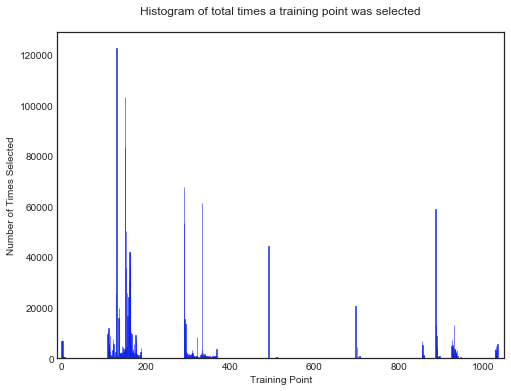

In [8]:
# Count number of times all samples were used
points_used = Counter(ada.all_samples)

# Plot the total # a sample was chosen when bootstrapping
plt.figure(figsize = (8,6))
plt.style.use('seaborn-white')
plt.bar(list(points_used.keys()), points_used.values(), linewidth = 0.5, edgecolor = 'blue')
plt.title('Histogram of total times a training point was selected\n')
plt.xlabel('Training Point')
plt.ylabel('Number of Times Selected')
plt.xlim([-10,1050]);

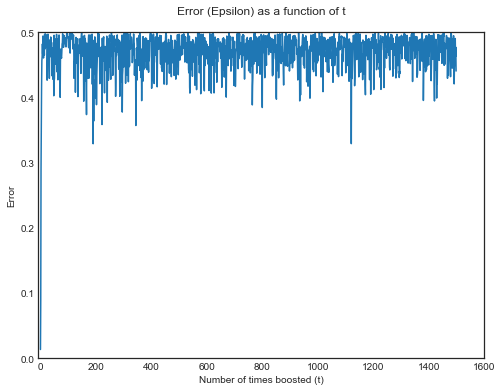

In [9]:
# Plot boosting error (epsilon) as a function of the number of times boosted
plt.figure(figsize = (8,6))
plt.plot(list(range(1500)), ada.errors)
plt.title('Error (Epsilon) as a function of t\n')
plt.xlabel('Number of times boosted (t)')
plt.ylabel('Error')
plt.ylim([0,0.501])
plt.xlim([-10,1600]);

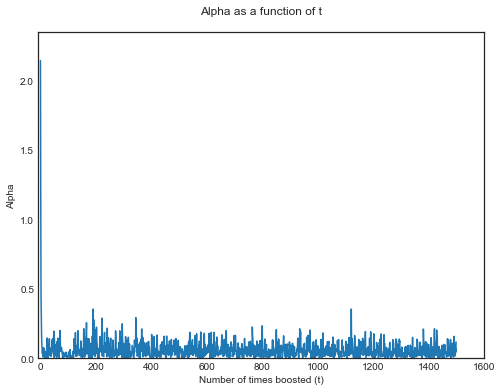

In [10]:
# Plot alpha as a function of the number of times boosted
plt.figure(figsize = (8,6))
plt.plot(list(range(1500)), ada.alphas)
plt.title('Alpha as a function of t\n')
plt.xlabel('Number of times boosted (t)')
plt.ylabel('Alpha')
plt.ylim([0,2.35])
plt.xlim([-10,1600]);